In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from pathlib import Path


In [4]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("behrad3d/nasa-cmaps")
#print("Path to dataset files:", path)

DATA_PATH = Path("datasets/CMaps/")
images_dir = "images"

# FD00X dataset prep

In [5]:
indexes = ['unit_number', 'time_cycles']
settings = ['setting_1', 'setting_2', 'setting_3']
sensors = ['s_{}'.format(i+1) for i in range(0,21)]
COLS = indexes + settings + sensors

In [6]:
Sensor_dictionary = {}
dict_list = [
    "Fan intake temperature (°R)",
    "Low-Pressure Compressor outlet temperature (°R)",
    "High-Pressure Compressor outlet temperature (°R)",
    "Low-Pressure Turbine outlet temperature (°R)",
    "Fan intake pressure (psia)",
    "Bypass-duct pressure (psia)",
    "High-Pressure Compressor outlet pressure (psia)",
    "Physical fan RPM",
    "Physical core RPM",
    "Engine pressure ratio (P50/P2)",
    "High-Pressure Compressor outlet static pressure (psia)",
    "Fuel flow to Ps30 ratio (pps/psia)",
    "Corrected fan RPM",
    "Corrected core RPM",
    "Bypass ratio",
    "Burner fuel-air ratio",
    "Bleed enthalpy",
    "Required fan RPM",
    "Required fan conversion RPM",
    "High-pressure turbine cooling airflow",
    "Low-pressure turbine cooling airflow"
]

Sensor_dictionary = {f's_{i+1}': sensor for i, sensor in enumerate(dict_list)}
Sensor_dictionary


{'s_1': 'Fan intake temperature (°R)',
 's_2': 'Low-Pressure Compressor outlet temperature (°R)',
 's_3': 'High-Pressure Compressor outlet temperature (°R)',
 's_4': 'Low-Pressure Turbine outlet temperature (°R)',
 's_5': 'Fan intake pressure (psia)',
 's_6': 'Bypass-duct pressure (psia)',
 's_7': 'High-Pressure Compressor outlet pressure (psia)',
 's_8': 'Physical fan RPM',
 's_9': 'Physical core RPM',
 's_10': 'Engine pressure ratio (P50/P2)',
 's_11': 'High-Pressure Compressor outlet static pressure (psia)',
 's_12': 'Fuel flow to Ps30 ratio (pps/psia)',
 's_13': 'Corrected fan RPM',
 's_14': 'Corrected core RPM',
 's_15': 'Bypass ratio',
 's_16': 'Burner fuel-air ratio',
 's_17': 'Bleed enthalpy',
 's_18': 'Required fan RPM',
 's_19': 'Required fan conversion RPM',
 's_20': 'High-pressure turbine cooling airflow',
 's_21': 'Low-pressure turbine cooling airflow'}

In [7]:
def load_fd_dataset(dataset_id):
    """
    Load train/test/RUL files for a single FD dataset (e.g., FD001, FD002, etc.)
    
    :param dataset_id: integer 1..4, e.g. for FD001 use dataset_id=1
    :return: df_train, df_test, df_rul (pandas DataFrames)
    """

    train_file = DATA_PATH / f"train_FD00{dataset_id}.txt"
    test_file  = DATA_PATH / f"test_FD00{dataset_id}.txt"
    rul_file   = DATA_PATH / f"RUL_FD00{dataset_id}.txt"

    df_train = pd.read_csv(
        train_file,
        sep=r"\s+",        
        header=None,
        names=COLS,
        index_col=False
    )

    df_test = pd.read_csv(
        test_file,
        sep=r"\s+",
        header=None,
        names=COLS,
        index_col=False
    )

    df_rul = pd.read_csv(
        rul_file,
        sep=r"\s+",
        header=None,
        names=["RUL"],
        index_col=False
    )
    
    return df_train, df_test, df_rul

def add_train_rul(df_train):
    """
    For the training set, calculate RUL for every row.
    NASA’s train data runs each engine to failure, so:
      RUL = (last cycle for that engine) - (current cycle).
    """
    # Group by unit and get the max cycle of each engine
    max_cycle = df_train.groupby("unit_number")["time_cycles"].transform("max")
    # RUL = distance to max cycle
    df_train["RUL"] = max_cycle - df_train["time_cycles"]
    return df_train

def add_test_rul(df_test, df_rul):
    """
    For the test set, each engine is truncated before failure. 
    NASA gives a single RUL for the *last* row of each engine in df_rul.
    
    Typically, we only need that final row to evaluate or predict RUL. 
    So we can 'merge' that RUL onto the final snapshot of each engine.
    
    If you want row-level RUL for the entire partial test run (less common),
    you need a different approach. Usually, we label only the last row.
    """
    # Identify the final row for each engine in the test set
    # i.e., the row with the maximum 'time_cycles' for that unit_number
    idx = df_test.groupby("unit_number")["time_cycles"].transform("max") == df_test["time_cycles"]
    final_test_rows = df_test[idx].copy().reset_index(drop=True)
    
    # Attach RUL from df_rul, which is one row per engine
    # RUL rows match by index => engine 1 => df_rul.loc[0], engine 2 => df_rul.loc[1], etc.
    # final_test_rows are also in ascending engine order, so we can do direct assignment
    final_test_rows["RUL"] = df_rul["RUL"]
    
    return final_test_rows


In [8]:
datasets = {}  

for i in range(1, 5):
    
    df_train_raw, df_test_raw, df_rul = load_fd_dataset(i)
    df_train = add_train_rul(df_train_raw)
    df_test_final = add_test_rul(df_test_raw, df_rul)
    key = f"FD00{i}"
    datasets[key] = {
        "train":       df_train,   
        "test":        df_test_raw,
        "rul":         df_rul,
        "test_final":  df_test_final,
    }

In [9]:
for ds_name, ds_dict in datasets.items():
    print(ds_name)
    print("  train shape:", ds_dict["train"].shape, "(includes computed RUL)")
    print("  test shape: ", ds_dict["test"].shape)
    print("  rul shape:  ", ds_dict["rul"].shape, "(one row per engine in test)")
    print("  final test shape (with RUL):", ds_dict["test_final"].shape)
    print()

FD001
  train shape: (20631, 27) (includes computed RUL)
  test shape:  (13096, 26)
  rul shape:   (100, 1) (one row per engine in test)
  final test shape (with RUL): (100, 27)

FD002
  train shape: (53759, 27) (includes computed RUL)
  test shape:  (33991, 26)
  rul shape:   (259, 1) (one row per engine in test)
  final test shape (with RUL): (259, 27)

FD003
  train shape: (24720, 27) (includes computed RUL)
  test shape:  (16596, 26)
  rul shape:   (100, 1) (one row per engine in test)
  final test shape (with RUL): (100, 27)

FD004
  train shape: (61249, 27) (includes computed RUL)
  test shape:  (41214, 26)
  rul shape:   (248, 1) (one row per engine in test)
  final test shape (with RUL): (248, 27)



In [10]:
datasets["FD001"]["train"]

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [11]:
datasets["FD001"]["train"].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit_number,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time_cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200


create distribution plot of max cycles

In [12]:
for ds_name, ds_dict in datasets.items():
    df_train = ds_dict["train"]
    fig_name = os.path.join(images_dir, f"{ds_name}_displot.png")
    
    if os.path.exists(fig_name):
        continue

    max_time_cycles = df_train.groupby("unit_number")["time_cycles"].max()
    sns.displot(
        data=max_time_cycles, 
        kde=True,
        bins=20,
        height=6,
        aspect=2,
    )
    plt.xlabel("Max Time Cycle")
    plt.title(f"Max Time Cycles Distribution – {ds_name}", fontsize=14)
    plt.savefig(fig_name)
    plt.close()


Create correlation_matrixes 

In [13]:
for ds_name, ds_dict in datasets.items():
    df_train = ds_dict["train"]
    fig_name = os.path.join(images_dir, f"{ds_name}_corr_heatmap.png")

    if os.path.exists(fig_name):
        continue

    corr = df_train.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(20, 20))
    cmap = sns.diverging_palette(230, 10, as_cmap=True)

    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmax=.3,
        center=0,
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .5},
        annot=True,
        fmt=".2f"
    )
    plt.title(f"Correlation Matrix Heatmap – {ds_name}", fontsize=14)
    plt.savefig(fig_name)
    plt.close()


In [14]:
signal_dir = os.path.join(images_dir, "signal_plots")
os.makedirs(signal_dir, exist_ok=True)
def plot_signal(df, Sensor_dic, signal_name, ds_name, images_dir):
    fig_name = os.path.join(signal_dir, f"{ds_name}_{signal_name}.png")
    if os.path.exists(fig_name):
        return

    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.title(f'{signal_name} - {ds_name}')
    plt.savefig(fig_name)
    plt.close()

for ds_name, ds_dict in datasets.items():
    df_train = ds_dict["train"]
    for i in range(1, 22):
        signal_name = f's_{i}'
        try:
            plot_signal(df_train, Sensor_dictionary, signal_name, ds_name, images_dir)
        except Exception as e:
            pass

In [15]:
boxplot_dir = os.path.join(images_dir, "box_plots")
os.makedirs(boxplot_dir, exist_ok=True)

for ds_name, ds_dict in datasets.items():
    df_train = ds_dict["train"]
    
    for i in range(1, 22):
        signal_name = f's_{i}'
        fig_name = os.path.join(boxplot_dir, f"{ds_name}_{signal_name}_boxplot.png")
        
        if os.path.exists(fig_name):
            continue

        plt.figure(figsize=(14, 6))
        sns.boxplot(x="unit_number", y=signal_name, data=df_train)
        plt.xticks(rotation=90)
        plt.title(f"Box Plot of {signal_name} by Unit – {ds_name}")
        plt.xlabel("Unit Number")
        plt.ylabel(Sensor_dictionary.get(signal_name, signal_name))  # fallback to raw name
        plt.tight_layout()
        plt.savefig(fig_name)
        plt.close()


## Linear Regression

In [16]:
linear_train = datasets["FD001"]["train"]
linear_test = datasets["FD001"]["test"]
linear_RUL = datasets["FD001"]["rul"]

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

gets rid of features with only one distinc value and other useless features like unit_number

In [18]:
drop_cols = ["unit_number", "time_cycles", "RUL", "s_1","s_5","s_6","s_10","s_16","s_18","s_19"]

feature_cols = [col for col in linear_train.columns if col not in drop_cols]
X_train = linear_train[feature_cols]
y_train = linear_train["RUL"]

idx = linear_test.groupby("unit_number")["time_cycles"].transform("max") == linear_test["time_cycles"]
linear_test_final = linear_test[idx].copy().reset_index(drop=True)

X_test = linear_test_final[feature_cols]
y_test = linear_RUL["RUL"]

scale values so it wont mess up the regression

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

FD001 Linear Regression Results:
Mean Absolute Error (MAE): 25.593806249891955
Root Mean Squared Error (RMSE): 32.04274103205501


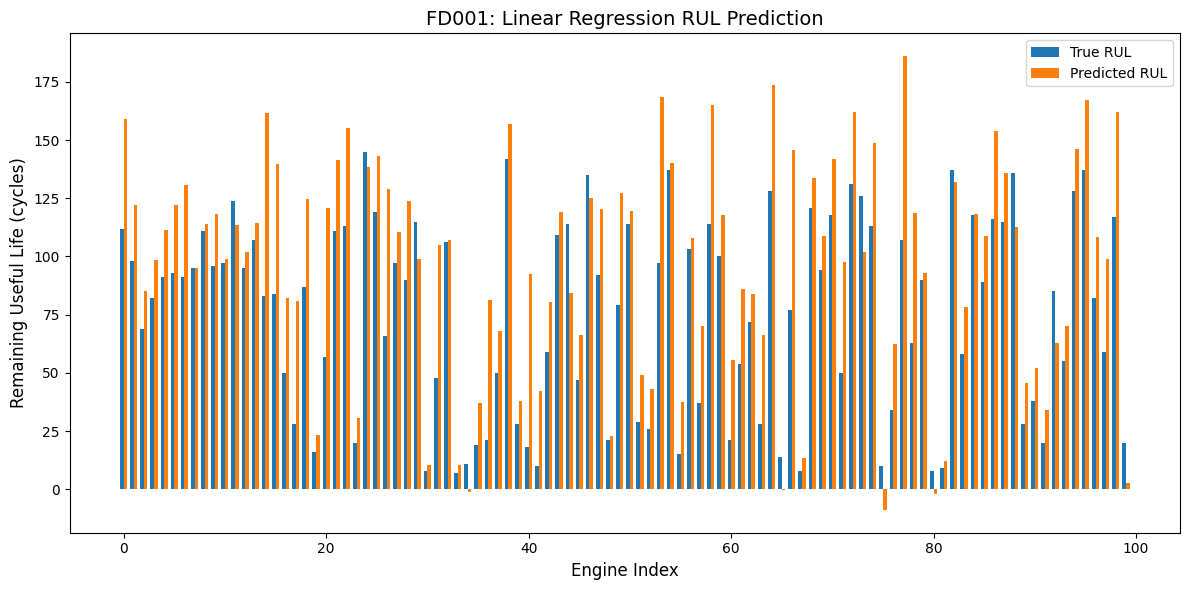

In [21]:
y_pred = model.predict(X_test_scaled)

# evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("FD001 Linear Regression Results:")
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot predicted vs. true RUL for visual inspection
n_engines = len(y_test)
indices = np.arange(n_engines)
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(indices - width/2, y_test, width, label="True RUL")
plt.bar(indices + width/2, y_pred, width, label="Predicted RUL")

plt.xlabel("Engine Index", fontsize=12)
plt.ylabel("Remaining Useful Life (cycles)", fontsize=12)
plt.title("FD001: Linear Regression RUL Prediction", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

we see that its sometimes off by ~30 cycles and on average its of by ~25 cycles

## SVR

In [22]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

use grid search to find the best arguments (takes 2 long to run)

In [23]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


# svr = SVR(kernel='rbf')
# param_grid = {
#     'C': np.logspace(-1, 2, num=10),        
#     'epsilon': np.linspace(0.1, 1, num=10),
#     'gamma': ['auto']
# }

# # Best SVR parameters: {'C': np.float64(4.6415888336127775), 'epsilon': np.float64(1.0), 'gamma': 'auto'}
# # FD001 SVR Results:
# # Mean Absolute Error (MAE): 19.317029448618865
# # Root Mean Squared Error (RMSE): 26.904835314347046

# grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train_scaled, y_train)


# best_svr = grid_search.best_estimator_
# print("Best SVR parameters:", grid_search.best_params_)

# y_pred = best_svr.predict(X_test_scaled)


# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print("FD001 SVR Results:")
# print("Mean Absolute Error (MAE):", mae)
# print("Root Mean Squared Error (RMSE):", rmse)

# n_engines = len(y_test)
# indices = np.arange(n_engines)
# bar_width = 0.35

# plt.figure(figsize=(12, 6))
# plt.bar(indices - bar_width/2, y_test, bar_width, label="True RUL")
# plt.bar(indices + bar_width/2, y_pred, bar_width, label="Predicted RUL")
# plt.xlabel("Engine Index", fontsize=12)
# plt.ylabel("Remaining Useful Life (cycles)", fontsize=12)
# plt.title("FD001: SVR RUL Prediction with GridSearchCV", fontsize=14)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [24]:

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
svr_model = SVR(kernel='rbf', C=4.6415888336127775, epsilon=1)
svr_model.fit(X_train_scaled, y_train)


SVR(C=4.6415888336127775, epsilon=1)

FD001 SVR Results:
Mean Absolute Error (MAE): 19.345326731353303
Root Mean Squared Error (RMSE): 26.91091557330584


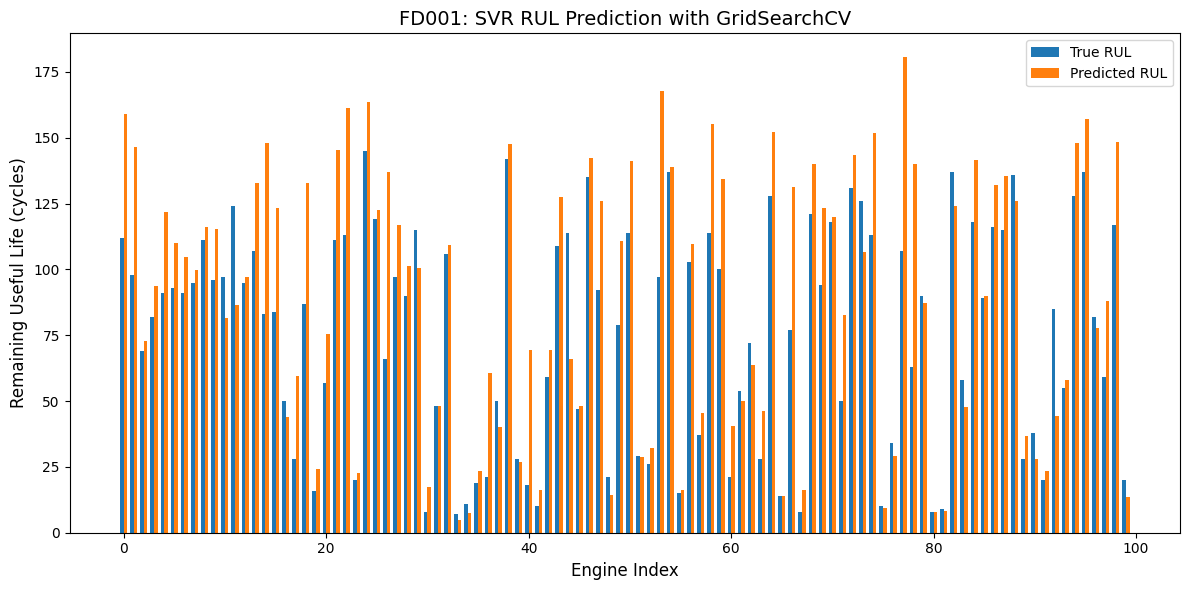

In [25]:
y_pred = svr_model.predict(X_test_scaled)


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("FD001 SVR Results:")
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

n_engines = len(y_test)
indices = np.arange(n_engines)
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width/2, y_test, bar_width, label="True RUL")
plt.bar(indices + bar_width/2, y_pred, bar_width, label="Predicted RUL")
plt.xlabel("Engine Index", fontsize=12)
plt.ylabel("Remaining Useful Life (cycles)", fontsize=12)
plt.title("FD001: SVR RUL Prediction with GridSearchCV", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

## SVR with historical data

In [ ]:
def create_history_features(df, feature_cols, window_size):
    """
    Generates training samples by constructing a sliding window of historical features.
    Each sample is built by flattening the sensor/setting values from the last 'window_size'
    cycles for a given engine. The target is the RUL at the end of that window.
    """
    X_hist = []
    y_hist = []
    
    # Process each engine separately
    for unit, group in df.groupby("unit_number"):
        group = group.sort_values("time_cycles")
        # Only generate samples if there are at least window_size cycles
        if len(group) < window_size:
            continue
        
        # For each index that can form a full window, extract the window and target
        for i in range(window_size - 1, len(group)):
            # Get the window data
            window_data = group.iloc[i - window_size + 1 : i + 1][feature_cols].values
            # Flatten the window
            window_flat = window_data.flatten()

            target = group.iloc[i]["RUL"]
            X_hist.append(window_flat)
            y_hist.append(target)
    return np.array(X_hist), np.array(y_hist)

def create_test_history_features(df, feature_cols, window_size):
    """
    For each engine in the test set, extract the final window (last window_size cycles)
    and flatten it into a feature vector. Returns an array of features and a corresponding
    list of engine identifiers.
    """
    X_test_hist = []
    unit_ids = []
    
    for unit, group in df.groupby("unit_number"):
        group = group.sort_values("time_cycles")
        if len(group) >= window_size:
            window_data = group.iloc[-window_size:][feature_cols].values
            window_flat = window_data.flatten()
            X_test_hist.append(window_flat)
            unit_ids.append(unit)
    return np.array(X_test_hist), unit_ids

In [53]:
window_size = 20

X_train_hist, y_train_hist = create_history_features(linear_train, feature_cols, window_size)
X_test_hist, test_unit_ids = create_test_history_features(linear_test, feature_cols, window_size)
y_test = linear_RUL["RUL"].values


scale historical

In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hist)
X_test_scaled = scaler.transform(X_test_hist)

randomized search for historical svr

In [36]:
from sklearn.model_selection import RandomizedSearchCV

svr = SVR(kernel='rbf')

param_dist = {
    'C': np.logspace(-1, 2, num=50),         
    'epsilon': np.linspace(0.1, 1, num=50),    # 10 values from 0.1 to 1
    'gamma': ['scale', 'auto']
}

random_search = RandomizedSearchCV(
    svr,
    param_dist,
    n_iter=20,         
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train_scaled, y_train_hist)
best_svr = random_search.best_estimator_

print("Best SVR parameters (RandomizedSearchCV):", random_search.best_params_)


y_pred = best_svr.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("FD001 SVR with Historical Values Results (RandomizedSearchCV):")
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END C=2.5595479226995357, epsilon=0.5775510204081633, gamma=scale; total time= 3.0min
[CV] END C=3.906939937054617, epsilon=0.8346938775510204, gamma=auto; total time= 3.0min
[CV] END C=3.906939937054617, epsilon=0.8346938775510204, gamma=auto; total time= 3.0min
[CV] END C=0.13257113655901093, epsilon=0.5959183673469388, gamma=scale; total time= 3.0min
[CV] END C=3.906939937054617, epsilon=0.8346938775510204, gamma=auto; total time= 3.0min
[CV] END C=0.13257113655901093, epsilon=0.5959183673469388, gamma=scale; total time= 3.0min
[CV] END C=2.5595479226995357, epsilon=0.5775510204081633, gamma=scale; total time= 3.0min
[CV] END C=0.3088843596477481, epsilon=0.5040816326530613, gamma=scale; total time= 3.0min
[CV] END C=2.5595479226995357, epsilon=0.5775510204081633, gamma=scale; total time= 3.0min
[CV] END C=3.906939937054617, epsilon=0.8346938775510204, gamma=auto; total time= 3.0min
[CV] END C=3.906939937054617, epsi

Now we plot the bar chart 

FD001 SVR Results (Manual hyperparameters):
Mean Absolute Error (MAE): 15.544541166613175
Root Mean Squared Error (RMSE): 21.522063912537


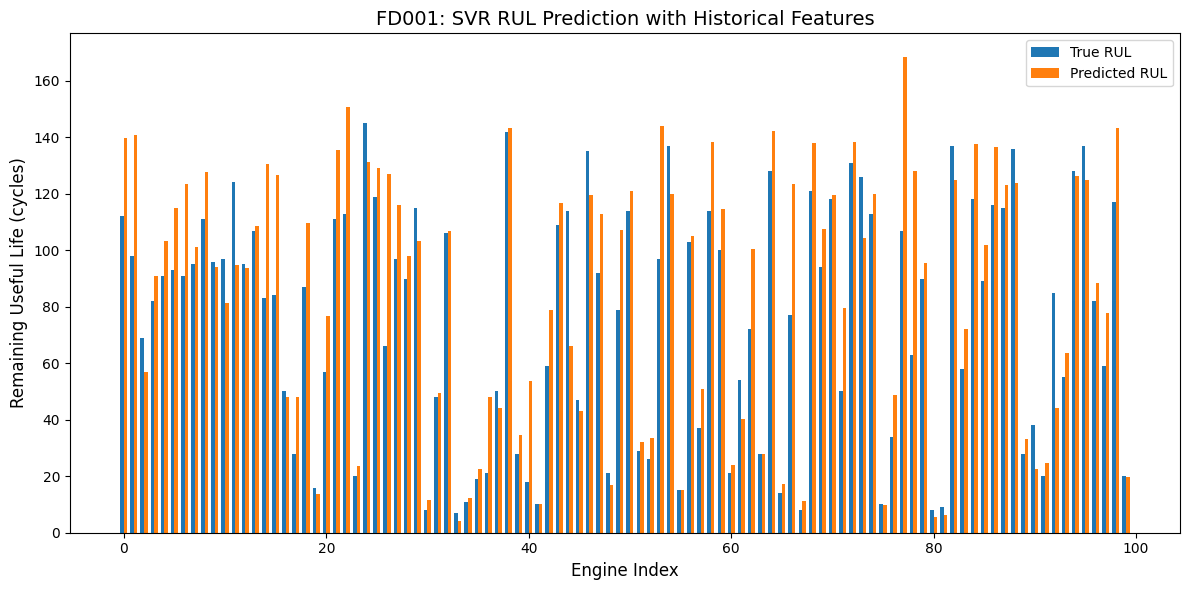

In [55]:
# Best SVR parameters (RandomizedSearchCV): {'gamma': 'auto', 'epsilon': np.float64(0.8346938775510204), 'C': np.float64(3.906939937054617)}
# FD001 SVR with Historical Values Results (RandomizedSearchCV):
# Mean Absolute Error (MAE): 18.99514649331861
# Root Mean Squared Error (RMSE): 26.70162935950417

svr = SVR(kernel='rbf', C=2.0, epsilon=0.8, gamma='scale')
svr.fit(X_train_scaled, y_train_hist)

y_pred = svr.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("FD001 SVR Results (Manual hyperparameters):")
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

n_engines = len(y_test)
indices = np.arange(n_engines)
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width/2, y_test, bar_width, label="True RUL")
plt.bar(indices + bar_width/2, y_pred, bar_width, label="Predicted RUL")
plt.xlabel("Engine Index", fontsize=12)
plt.ylabel("Remaining Useful Life (cycles)", fontsize=12)
plt.title("FD001: SVR RUL Prediction with Historical Features", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()
